# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to find a basic workflow for doing machine learning classification of an imbalanced dataset using best practices taken from other people's examples.

# Binary Classification Proof of Concept

## References

**::GMG::** This one:

  - [STHDA](http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/) Penalized Logistic Regression Essentials in R: Ridge, Lasso and Elastic Net by kassambara -- 11/03/2018 from  [Articles](http://www.sthda.com/english/articles/36-classification-methods-essentials/) - Classification Methods Essentials

## Libraries

In [1]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [2]:
using('tidyverse','caret','glmnet', 'mlbench')

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: caret
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-18

Loading required package: mlbench


**::GMG::** `tidyverse` first install here:

```R
Loading required package: tidyverse
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tidyverse’”Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘tinytex’, ‘rmarkdown’, ‘selectr’, ‘broom’, ‘dbplyr’, ‘modelr’, ‘reprex’, ‘rvest’

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::lift()       masks caret::lift()
✖ purrr::when()       masks foreach::when()
                           
    1. TRUE
``` 

## Dataset

In [3]:
#::GMG::There are two versions in mlbench
#::NOTE::2nd version comes with zero outliers as NAs
data(PimaIndiansDiabetes2)

In [4]:
head(PimaIndiansDiabetes2)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,pos
1,85,66,29,NA,26.6,0.351,31,neg
8,183,64,NA,NA,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,NA,NA,25.6,0.201,30,neg


## Exploratory Data Analysis

**::GMG::** The goal of this stage of our study is to get to know the data, their flaws and perhaps some clues to improve them.

In [5]:
#::GMG::PimaIndiansDiabetes2 (say, v2) has the outliers from 
#       glucose, pressure, triceps, insulin and mass as NAs
str(PimaIndiansDiabetes2)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 NA 70 96 ...
 $ triceps : num  35 29 NA 23 35 NA 32 NA 45 NA ...
 $ insulin : num  NA NA NA 94 168 NA 88 NA 543 NA ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 NA ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [6]:
#::GMG::NA counts yield the outliers (!)
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00            
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 M

In [7]:
#::GMG::Check for missing values ... I know they are marked witn 'NA' in mlbench 2nd dataset
sapply(PimaIndiansDiabetes2, function(x) sum(is.na(x)))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        5       35      227      374       11        0        0 
diabetes 
       0

In [8]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(PimaIndiansDiabetes2$diabetes)


neg pos 
500 268 

In [9]:
prop.table(table(PimaIndiansDiabetes2$diabetes))


      neg       pos 
0.6510417 0.3489583 

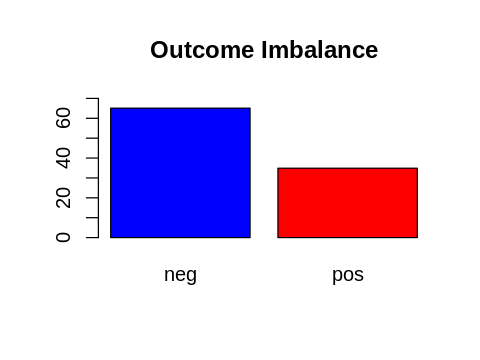

In [10]:
#::GMG::Plot the imbalance
# https://www.statmethods.net/advgraphs/parameters.html
# http://www.programmingr.com/content/positioning-charts-fig-and-fin/
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
# https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
options(repr.plot.width=4, repr.plot.height=3)
barplot(100*prop.table(table(PimaIndiansDiabetes2$diabetes)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Preparing the data

In [11]:
# Load the data and remove NAs
#::NOTE::I've already attached that dataset earlier
#data("PimaIndiansDiabetes2", package = "mlbench")
# https://www.rdocumentation.org/packages/data.table/versions/1.12.2/topics/na.omit.data.table
# https://www.statmethods.net/input/missingdata.html
pima_clean <- na.omit(PimaIndiansDiabetes2)

In [12]:
#::GMG::Check for missing values ... No NAs after cleaning with na.omit()
sapply(pima_clean, function(x) sum(is.na(x)))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        0        0        0        0        0        0        0 
diabetes 
       0

In [13]:
# Inspect the data
# https://dplyr.tidyverse.org/reference/sample.html
dplyr::sample_n(pima_clean, 3)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,97,64,19,82,18.2,0.299,21,neg
0,124,56,13,105,21.8,0.452,21,neg
2,121,70,32,95,39.1,0.886,23,neg


In [14]:
#::NOTE::Originally 768 Observations!!
str(pima_clean)

'data.frame':	392 obs. of  9 variables:
 $ pregnant: num  1 0 3 2 1 5 0 1 1 3 ...
 $ glucose : num  89 137 78 197 189 166 118 103 115 126 ...
 $ pressure: num  66 40 50 70 60 72 84 30 70 88 ...
 $ triceps : num  23 35 32 45 23 19 47 38 30 41 ...
 $ insulin : num  94 168 88 543 846 175 230 83 96 235 ...
 $ mass    : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ pedigree: num  0.167 2.288 0.248 0.158 0.398 ...
 $ age     : num  21 33 26 53 59 51 31 33 32 27 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 2 2 2 2 2 2 1 2 1 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


In [15]:
#::NOTE::Make it reproducible
set.seed(123)

In [16]:
# Split the data into training and test set
#::NOTE::using caret to do the stratified split and dplyr %>% notation
# https://topepo.github.io/caret/data-splitting.html
# https://github.com/tidyverse/dplyr
training_samples <- pima_clean$diabetes %>% 
  caret::createDataPartition(p = 0.8, list = FALSE)

In [17]:
#::NOTE::Do the actual split with the indices just computed
train_data  <- pima_clean[training_samples, ]
test_data <- pima_clean[-training_samples, ]

In [18]:
#::NOTE::See the split datasets
str(train_data)

'data.frame':	314 obs. of  9 variables:
 $ pregnant: num  1 0 3 2 1 5 0 1 11 10 ...
 $ glucose : num  89 137 78 197 189 166 118 115 143 125 ...
 $ pressure: num  66 40 50 70 60 72 84 70 94 70 ...
 $ triceps : num  23 35 32 45 23 19 47 30 33 26 ...
 $ insulin : num  94 168 88 543 846 175 230 96 146 115 ...
 $ mass    : num  28.1 43.1 31 30.5 30.1 25.8 45.8 34.6 36.6 31.1 ...
 $ pedigree: num  0.167 2.288 0.248 0.158 0.398 ...
 $ age     : num  21 33 26 53 59 51 31 32 51 41 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 2 2 2 2 2 2 2 2 2 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


In [19]:
str(test_data)

'data.frame':	78 obs. of  9 variables:
 $ pregnant: num  1 3 3 7 2 2 5 4 1 6 ...
 $ glucose : num  103 126 158 150 141 100 139 129 71 93 ...
 $ pressure: num  30 88 76 66 58 66 64 86 48 50 ...
 $ triceps : num  38 41 36 42 34 20 35 20 18 30 ...
 $ insulin : num  83 235 245 342 128 90 140 270 76 64 ...
 $ mass    : num  43.3 39.3 31.6 34.7 25.4 32.9 28.6 35.1 20.4 28.7 ...
 $ pedigree: num  0.183 0.704 0.851 0.718 0.699 0.867 0.411 0.231 0.323 0.356 ...
 $ age     : num  33 27 28 42 24 28 26 23 22 23 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 1 2 1 1 2 1 1 1 1 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


In [20]:
#::NOTE::The R function model.matrix() helps to create the matrix of predictors and also automatically 
#        converts categorical predictors to appropriate dummy variables, which is required for the glmnet() 
#        function.
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/model.matrix
# Dumy code categorical predictor variables
X_train <- stats::model.matrix(diabetes~., train_data)[,-1]

In [21]:
# Convert the outcome (class) to a numerical variable
y_train <- ifelse(train_data$diabetes == "pos", 1, 0)

In [22]:
#::NOTE::Check the results (a named 2D matrix of features)
str(X_train)

 num [1:314, 1:8] 1 0 3 2 1 5 0 1 11 10 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:314] "4" "5" "7" "9" ...
  ..$ : chr [1:8] "pregnant" "glucose" "pressure" "triceps" ...


In [23]:
#::NOTE::Check the results (a numeric 1/0 vector)
str(y_train)

 num [1:314] 0 1 1 1 1 1 1 1 1 1 ...


## LASSO

### computing cv for lambda

In [24]:
#::NOTE::Make it reproducible
set.seed(123) 

In [25]:
#::NOTE::In penalized regression, you need to specify a constant lambda to adjust the amount of 
#        the coefficient shrinkage. The best lambda for your data, can be defined as the lambda 
#        that minimize the cross-validation prediction error rate. This can be determined automatically 
#        using the function cv.glmnet()
# https://www.rdocumentation.org/packages/glmnet/versions/2.0-18/topics/cv.glmnet
#::NOTE::compute lasso regression by specifying the option alpha = 1
# Find the optimal value of lambda that minimizes the cross-validation error:
cv_lasso <- glmnet::cv.glmnet(x = X_train, 
                              y = y_train, 
                              alpha = 1, 
                              family = "binomial")

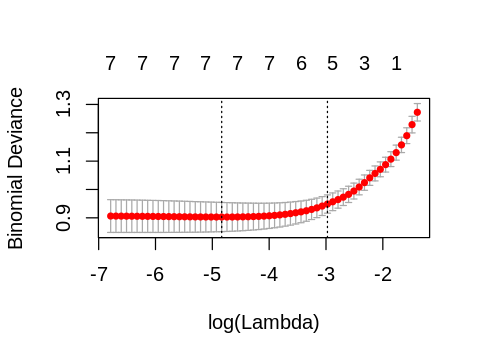

In [26]:
#::NOTE::See graphically the best lambda
plot(cv_lasso)

The plot displays the cross-validation error according to the log of lambda. The left dashed vertical line indicates that the log of the optimal value of lambda is approximately -5, which is the one that minimizes the prediction error. This lambda value will give the most accurate model. The exact value of lambda can be viewed as follow:

In [27]:
cat('Optimum lambda: ', cv_lasso$lambda.min)

Optimum lambda:  0.00794607

Generally, the purpose of regularization is to balance accuracy and simplicity. This means, a model with the smallest number of predictors that also gives a good accuracy. To this end, the function `cv.glmnet()` finds also the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. This value is called `lambda.1se`.

In [28]:
cat('Simplest model within one se of lambda optimum: ', cv_lasso$lambda.1se)

Simplest model within one se of lambda optimum:  0.05107792

Using lambda.min as the best lambda, gives the following regression coefficients:

In [29]:
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/coef (?)
stats::coef(cv_lasso, cv_lasso$lambda.min)

9 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -9.5832830912
pregnant     0.0799668932
glucose      0.0348640320
pressure     .           
triceps      0.0118761033
insulin      0.0003828257
mass         0.0697546400
pedigree     1.0827803077
age          0.0263611037

In [30]:
#::NOTE:the "native" glmnet packaage coef() (same result)
glmnet::coef.cv.glmnet(cv_lasso, cv_lasso$lambda.min)

9 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -9.5832830912
pregnant     0.0799668932
glucose      0.0348640320
pressure     .           
triceps      0.0118761033
insulin      0.0003828257
mass         0.0697546400
pedigree     1.0827803077
age          0.0263611037

**(?)** From the output above, only the viable `triceps` has a coefficient exactly equal to zero.

**::NOTE::** I can't see that claim looking at the results above.

Using `lambda.1se` as the best lambda, gives the following regression coefficients:

In [31]:
coef(cv_lasso, cv_lasso$lambda.1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -6.153688978
pregnant     0.005428000
glucose      0.026897916
pressure     .          
triceps      0.003555793
insulin      .          
mass         0.033598175
pedigree     0.219668158
age          0.022408781

Using lambda.1se, only **2 variables** (**?**) (*NOTE*: in the original article they're five with the dot) have non-zero coefficients. The coefficients of all other variables have been set to zero by the lasso algorithm, reducing the complexity of the model.

Setting lambda = lambda.1se produces a simpler model compared to lambda.min, but the model might be a little bit less accurate than the one obtained with lambda.min.

### computing final model with best lambda

In [32]:
# Fit the final model on the training data and lambda.min
model_lambda_min <- glmnet(
    X_train, 
    y_train, 
    alpha = 1, 
    family = "binomial",
    lambda = cv_lasso$lambda.min
)

In [33]:
# Display regression coefficients
coef(model_lambda_min)

9 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept) -9.5834885138
pregnant     0.0799808517
glucose      0.0348646613
pressure     .           
triceps      0.0118672779
insulin      0.0003826888
mass         0.0697657308
pedigree     1.0828217871
age          0.0263599979

In [34]:
# Make predictions on the test data
X_test <- model.matrix(diabetes ~., test_data)[,-1]
probabilities <- model_lambda_min %>% predict(newx = X_test)
predicted_classes <- ifelse(probabilities > 0.5, "pos", "neg")

In [35]:
# Model accuracy
observed_classes <- test_data$diabetes
cat('Accuracy Model lambda_min: ', mean(predicted_classes == observed_classes))

Accuracy Model lambda_min:  0.7564103

In [36]:
# Final model with lambda.1se
model_lambda_1se <- glmnet(
    X_train, 
    y_train, 
    alpha = 1, 
    family = "binomial",
    lambda = cv_lasso$lambda.1se
)

In [37]:
# Display regression coefficients
coef(model_lambda_1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -6.154133389
pregnant     0.005400720
glucose      0.026895928
pressure     .          
triceps      0.003506442
insulin      .          
mass         0.033645833
pedigree     0.219787112
age          0.022427147

In [38]:
# Make prediction on test data
#X_test <- model.matrix(diabetes ~., test_data)[,-1]
probabilities_1se <- model_lambda_1se %>% predict(newx = X_test)
predicted_classes_1se <- ifelse(probabilities_1se > 0.5, "pos", "neg")

In [39]:
# Model accuracy rate
#observed_classes <- test_data$diabetes
cat('Accuracy Model lambda_1se: ', mean(predicted_classes_1se == observed_classes))

Accuracy Model lambda_1se:  0.7820513

**::NOTE::** In the original article the simplified model yields *worse* accuracy. Here I get **better** accuracy (**?**)

**::GMG::** I'll compare the accuracy obtained with lasso regression against the one obtained using the full logistic regression model (including all predictors).

## compute the full logistic model

In [40]:
# Fit the model
full_model <- glm(formula = diabetes ~., 
                  data = train_data, 
                  family = "binomial")

In [41]:
# Display regression coefficients
coef(full_model)

(Intercept)      pregnant       glucose      pressure       triceps 
-1.053400e+01  1.005031e-01  3.709621e-02 -3.875933e-04  1.417771e-02 
      insulin          mass      pedigree           age 
 5.939876e-04  7.997447e-02  1.329149e+00  2.718224e-02

In [42]:
# Make predictions
probabilities_full <- full_model %>% predict(newdata = test_data, type = "response")
predicted_classes_full <- ifelse(probabilities_full > 0.5, "pos", "neg")

In [43]:
# Model accuracy
#observed_classes <- test_data$diabetes
cat('Accuracy Full Model: ', mean(predicted_classes_full == observed_classes))

Accuracy Full Model:  0.7564103